In [1]:
import pandas as pd
import numpy as np

from config import CSV_FILE_URL
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from yellowbrick.model_selection import FeatureImportances
from sklearn.feature_selection import SelectFromModel

## Read Data

In [2]:
df = pd.read_csv(CSV_FILE_URL)
df.shape

(284807, 31)

## Clean Data

In [3]:
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Exploration

In [4]:
df.groupby('Class').count()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,...,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315
1,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492


<AxesSubplot:xlabel='Class'>

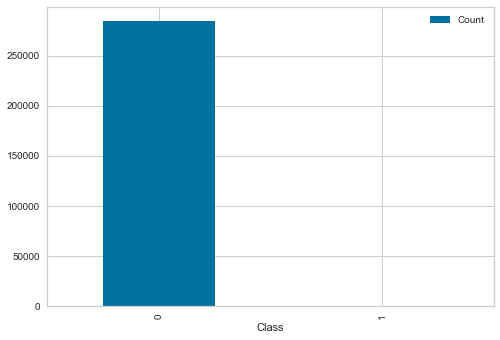

In [5]:
grouped_df = df[['Class','Time']].groupby('Class').count()
grouped_df = grouped_df.rename(columns={"Time":"Count"})
grouped_df.plot(kind="bar")

##### It is evident from the above plot that data is highly imbalanced. The dataset has only 492 fraudulent transactions out of a total of 284,807 transactions, which is a mere 0.17%.

## Defining Features

In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
selected_features = df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']]
selected_features

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00


In [8]:
X = selected_features
y = df[['Class']].values.reshape(-1, 1)

print("Shape: ", X.shape, y.shape)

Shape:  (284807, 30) (284807, 1)


## Create a Train Test Split

In [9]:
 # Use sklearn's `train_test_split` to split the data into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
print("Shape: ", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Shape:  (213605, 30) (213605, 1) (71202, 30) (71202, 1)


## Data Pre-processing

#### Scale the data using the MINMaxScaler

In [11]:
# Scale your data

X_minmax = MinMaxScaler().fit(X_train)

X_train_scaled = X_minmax.transform(X_train)
X_test_scaled = X_minmax.transform(X_test)

## Logistic Regression Model

### Train the Model

In [12]:
logisticRegressionModel = LogisticRegression()
logisticRegressionModel

LogisticRegression()

In [13]:
logisticRegressionModel.fit(X_train_scaled, y_train.flatten())

LogisticRegression()

In [14]:
print(f"Training Data Score: {logisticRegressionModel.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {logisticRegressionModel.score(X_test_scaled, y_test)}")

Training Data Score: 0.9990636923292994
Testing Data Score: 0.9990590151962023


In [15]:
# Make predictions with the logistcRegressionModel
logisticRegressionPredictions = logisticRegressionModel.predict(X_test_scaled)

In [16]:
logisticRegressionPredictProba = logisticRegressionModel.predict_proba(X_test_scaled)[:,1]

In [17]:
# Print classification report

print(classification_report(y_test.flatten(), logisticRegressionPredictions,
                            target_names=["Non Fradulent", "Fradulent"]))
print("Accuracy:", accuracy_score(y_test.flatten(), logisticRegressionPredictions))

               precision    recall  f1-score   support

Non Fradulent       1.00      1.00      1.00     71089
    Fradulent       0.82      0.52      0.64       113

     accuracy                           1.00     71202
    macro avg       0.91      0.76      0.82     71202
 weighted avg       1.00      1.00      1.00     71202

Accuracy: 0.9990590151962023


Logistic Regression
Accuracy:  0.9990590151962023
Precision:  0.8194444444444444
Recall:  0.5221238938053098
F1-Score:  0.637837837837838
AUC score:  0.7609705122221839
                precision    recall  f1-score   support

Non Fraudulent       1.00      1.00      1.00     71089
    Fraudulent       0.82      0.52      0.64       113

      accuracy                           1.00     71202
     macro avg       0.91      0.76      0.82     71202
  weighted avg       1.00      1.00      1.00     71202



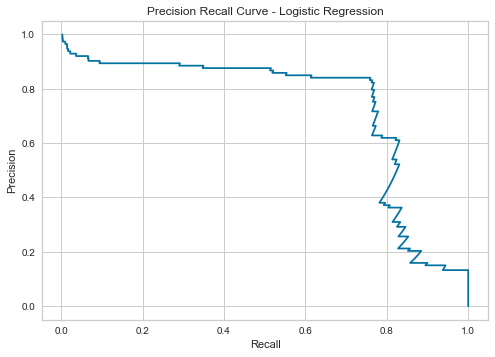

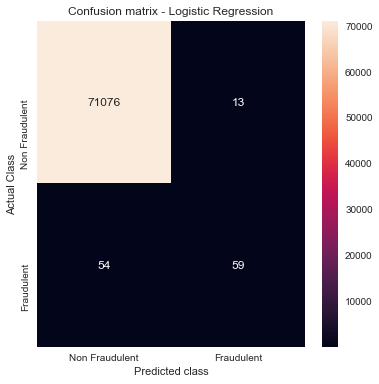

In [18]:
print("Logistic Regression")
print("===================")
print("Accuracy: ",accuracy_score(y_test.flatten(), logisticRegressionPredictions)) 
print("Precision: ",precision_score(y_test.flatten(), logisticRegressionPredictions))
print("Recall: ",recall_score(y_test.flatten(), logisticRegressionPredictions))
print("F1-Score: ",f1_score(y_test.flatten(), logisticRegressionPredictions))
print("AUC score: ",roc_auc_score(y_test.flatten(), logisticRegressionPredictions))
print(classification_report(y_test.flatten(), logisticRegressionPredictions,
                            target_names=["Non Fraudulent", "Fraudulent"]))
p, r, t = precision_recall_curve(y_test.flatten(), logisticRegressionPredictProba)
plt.plot(p, r)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve - Logistic Regression')
confusionMatrix = confusion_matrix(y_test.flatten(), logisticRegressionPredictions) 
plt.figure(figsize =(6, 6)) 
sns.heatmap(confusionMatrix, xticklabels = ['Non Fraudulent', 'Fraudulent'],  
            yticklabels = ['Non Fraudulent', 'Fraudulent'], annot = True, fmt ="d"); 
plt.title("Confusion matrix - Logistic Regression") 
plt.ylabel('Actual Class') 
plt.xlabel('Predicted class') 
plt.show() 

## Hyperparameter Tuning

### Use GridSearch to tune the model's parameters

In [19]:
logisticRegressionModel.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [20]:

logisticRegressionParam_grid = {'C': [1, 5, 10, 50],
              'penalty': ['l2','none'],
              'class_weight': [{0:1, 1:1, 2:2}, "balanced", None]}
logisticRegressionGrid = GridSearchCV(logisticRegressionModel, logisticRegressionParam_grid, verbose=3)

In [21]:
# Train the model with GridSearch
logisticRegressionGrid.fit(X_train_scaled, y_train.flatten())

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ................
[CV]  C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.1s
[CV] C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ................
[CV]  C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.0s
[CV] C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ................
[CV]  C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.0s
[CV] C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/joblib/para


[CV]  C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.0s
[CV] C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ................
[CV]  C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.1s
[CV] C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=none ..............
[CV]  C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=none ..............


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Appl

[CV]  C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.1s
[CV] C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=none ..............
[CV]  C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.1s
[CV] C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=none ..............
[CV]  C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=none ..............
[CV]  C=1, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l2 ..........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Appl

[CV]  C=1, class_weight=balanced, penalty=l2, score=0.980, total=   1.4s
[CV] C=1, class_weight=balanced, penalty=l2 ..........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1, class_weight=balanced, penalty=l2, score=0.983, total=   1.3s
[CV] C=1, class_weight=balanced, penalty=l2 ..........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1, class_weight=balanced, penalty=l2, score=0.975, total=   1.2s
[CV] C=1, class_weight=balanced, penalty=l2 ..........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1, class_weight=balanced, penalty=l2, score=0.977, total=   1.2s
[CV] C=1, class_weight=balanced, penalty=l2 ..........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1, class_weight=balanced, penalty=l2, score=0.977, total=   1.3s
[CV] C=1, class_weight=balanced, penalty=none ........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1, class_weight=balanced, penalty=none, score=0.976, total=   1.3s
[CV] C=1, class_weight=balanced, penalty=none ........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1, class_weight=balanced, penalty=none, score=0.979, total=   1.2s
[CV] C=1, class_weight=balanced, penalty=none ........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1, class_weight=balanced, penalty=none, score=0.973, total=   1.3s
[CV] C=1, class_weight=balanced, penalty=none ........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1, class_weight=balanced, penalty=none, score=0.971, total=   1.3s
[CV] C=1, class_weight=balanced, penalty=none ........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1, class_weight=balanced, penalty=none, score=0.972, total=   1.3s
[CV] C=1, class_weight=None, penalty=l2 ..............................
[CV] .. C=1, class_weight=None, penalty=l2, score=0.999, total=   1.1s
[CV] C=1, class_weight=None, penalty=l2 ..............................
[CV] .. C=1, class_weight=None, penalty=l2, score=0.999, total=   1.0s
[CV] C=1, class_weight=None, penalty=l2 ..............................
[CV] .. C=1, class_weight=None, penalty=l2, score=0.999, total=   0.9s
[CV] C=1, class_weight=None, penalty=l2 ..............................
[CV] .. C=1, class_weight=None, penalty=l2, score=0.999, total=   0.9s
[CV] C=1, class_weight=None, penalty=l2 ..............................
[CV] .. C=1, class_weight=None, penalty=l2, score=0.999, total=   1.1s
[CV] C=1, class_weight=None, penalty=none ............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=1, class_weight=None, penalty=none ............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=1, class_weight=None, penalty=none ............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=1, class_weight=None, penalty=none ............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=1, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=1, class_weight=None, penalty=none ............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_tr

[CV]  C=1, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ................
[CV]  C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.1s
[CV] C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ................
[CV]  C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.0s
[CV] C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ................
[CV]  C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.0s
[CV] C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Appl

[CV]  C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.0s
[CV] C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ................
[CV]  C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.0s
[CV] C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=none ..............
[CV]  C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=none ..............
[CV]  C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=none ..............
[CV]  C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=none ..............


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/joblib/pa

[CV]  C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=none ..............
[CV]  C=5, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=5, class_weight=balanced, penalty=l2 ..........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=5, class_weight=balanced, penalty=l2, score=0.979, total=   1.2s
[CV] C=5, class_weight=balanced, penalty=l2 ..........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=5, class_weight=balanced, penalty=l2, score=0.982, total=   1.3s
[CV] C=5, class_weight=balanced, penalty=l2 ..........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=5, class_weight=balanced, penalty=l2, score=0.974, total=   1.3s
[CV] C=5, class_weight=balanced, penalty=l2 ..........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=5, class_weight=balanced, penalty=l2, score=0.974, total=   1.2s
[CV] C=5, class_weight=balanced, penalty=l2 ..........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=5, class_weight=balanced, penalty=l2, score=0.975, total=   1.2s
[CV] C=5, class_weight=balanced, penalty=none ........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=5, class_weight=balanced, penalty=none, score=0.976, total=   1.3s
[CV] C=5, class_weight=balanced, penalty=none ........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=5, class_weight=balanced, penalty=none, score=0.979, total=   1.2s
[CV] C=5, class_weight=balanced, penalty=none ........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=5, class_weight=balanced, penalty=none, score=0.973, total=   1.3s
[CV] C=5, class_weight=balanced, penalty=none ........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=5, class_weight=balanced, penalty=none, score=0.971, total=   1.3s
[CV] C=5, class_weight=balanced, penalty=none ........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=5, class_weight=balanced, penalty=none, score=0.972, total=   1.3s
[CV] C=5, class_weight=None, penalty=l2 ..............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .. C=5, class_weight=None, penalty=l2, score=0.999, total=   1.1s
[CV] C=5, class_weight=None, penalty=l2 ..............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .. C=5, class_weight=None, penalty=l2, score=0.999, total=   1.2s
[CV] C=5, class_weight=None, penalty=l2 ..............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .. C=5, class_weight=None, penalty=l2, score=0.999, total=   1.2s
[CV] C=5, class_weight=None, penalty=l2 ..............................
[CV] .. C=5, class_weight=None, penalty=l2, score=0.999, total=   1.2s
[CV] C=5, class_weight=None, penalty=l2 ..............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .. C=5, class_weight=None, penalty=l2, score=0.999, total=   1.1s
[CV] C=5, class_weight=None, penalty=none ............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=5, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=5, class_weight=None, penalty=none ............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=5, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=5, class_weight=None, penalty=none ............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=5, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=5, class_weight=None, penalty=none ............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=5, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=5, class_weight=None, penalty=none ............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_tr

[CV]  C=5, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ...............
[CV]  C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.1s
[CV] C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ...............
[CV]  C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.0s
[CV] C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ...............
[CV]  C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.0s
[CV] C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ...............


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Appl

[CV]  C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.0s
[CV] C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ...............
[CV]  C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.0s
[CV] C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=none .............
[CV]  C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=none .............
[CV]  C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=none .............
[CV]  C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=none .............


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/joblib/pa

[CV]  C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=none .............
[CV]  C=10, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l2 .........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10, class_weight=balanced, penalty=l2, score=0.978, total=   1.2s
[CV] C=10, class_weight=balanced, penalty=l2 .........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10, class_weight=balanced, penalty=l2, score=0.980, total=   1.3s
[CV] C=10, class_weight=balanced, penalty=l2 .........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10, class_weight=balanced, penalty=l2, score=0.975, total=   1.2s
[CV] C=10, class_weight=balanced, penalty=l2 .........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10, class_weight=balanced, penalty=l2, score=0.973, total=   1.3s
[CV] C=10, class_weight=balanced, penalty=l2 .........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=10, class_weight=balanced, penalty=l2, score=0.975, total=   1.2s
[CV] C=10, class_weight=balanced, penalty=none .......................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=10, class_weight=balanced, penalty=none, score=0.976, total=   1.3s
[CV] C=10, class_weight=balanced, penalty=none .......................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=10, class_weight=balanced, penalty=none, score=0.979, total=   1.3s
[CV] C=10, class_weight=balanced, penalty=none .......................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=10, class_weight=balanced, penalty=none, score=0.973, total=   1.3s
[CV] C=10, class_weight=balanced, penalty=none .......................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=10, class_weight=balanced, penalty=none, score=0.971, total=   1.3s
[CV] C=10, class_weight=balanced, penalty=none .......................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=10, class_weight=balanced, penalty=none, score=0.972, total=   1.3s
[CV] C=10, class_weight=None, penalty=l2 .............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] . C=10, class_weight=None, penalty=l2, score=0.999, total=   1.2s
[CV] C=10, class_weight=None, penalty=l2 .............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] . C=10, class_weight=None, penalty=l2, score=0.999, total=   1.1s
[CV] C=10, class_weight=None, penalty=l2 .............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] . C=10, class_weight=None, penalty=l2, score=0.999, total=   1.2s
[CV] C=10, class_weight=None, penalty=l2 .............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] . C=10, class_weight=None, penalty=l2, score=0.999, total=   1.2s
[CV] C=10, class_weight=None, penalty=l2 .............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] . C=10, class_weight=None, penalty=l2, score=0.999, total=   1.2s
[CV] C=10, class_weight=None, penalty=none ...........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=10, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=10, class_weight=None, penalty=none ...........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=10, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=10, class_weight=None, penalty=none ...........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=10, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=10, class_weight=None, penalty=none ...........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=10, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=10, class_weight=None, penalty=none ...........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_tr

[CV]  C=10, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ...............
[CV]  C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.1s
[CV] C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ...............
[CV]  C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.0s
[CV] C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ...............


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Appl

[CV]  C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.1s
[CV] C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ...............
[CV]  C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.0s
[CV] C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2 ...............
[CV]  C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=l2, score=nan, total=   0.0s
[CV] C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=none .............
[CV]  C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=none .............
[CV]  C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=none .............

/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/joblib/pa


[CV]  C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=none .............
[CV]  C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=none .............
[CV]  C=50, class_weight={0: 1, 1: 1, 2: 2}, penalty=none, score=nan, total=   0.0s
[CV] C=50, class_weight=balanced, penalty=l2 .........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=50, class_weight=balanced, penalty=l2, score=0.979, total=   1.2s
[CV] C=50, class_weight=balanced, penalty=l2 .........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=50, class_weight=balanced, penalty=l2, score=0.979, total=   1.2s
[CV] C=50, class_weight=balanced, penalty=l2 .........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=50, class_weight=balanced, penalty=l2, score=0.973, total=   1.2s
[CV] C=50, class_weight=balanced, penalty=l2 .........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=50, class_weight=balanced, penalty=l2, score=0.972, total=   1.2s
[CV] C=50, class_weight=balanced, penalty=l2 .........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=50, class_weight=balanced, penalty=l2, score=0.973, total=   1.2s
[CV] C=50, class_weight=balanced, penalty=none .......................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=50, class_weight=balanced, penalty=none, score=0.976, total=   1.3s
[CV] C=50, class_weight=balanced, penalty=none .......................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=50, class_weight=balanced, penalty=none, score=0.979, total=   1.2s
[CV] C=50, class_weight=balanced, penalty=none .......................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=50, class_weight=balanced, penalty=none, score=0.973, total=   1.3s
[CV] C=50, class_weight=balanced, penalty=none .......................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=50, class_weight=balanced, penalty=none, score=0.971, total=   1.3s
[CV] C=50, class_weight=balanced, penalty=none .......................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  C=50, class_weight=balanced, penalty=none, score=0.972, total=   1.3s
[CV] C=50, class_weight=None, penalty=l2 .............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] . C=50, class_weight=None, penalty=l2, score=0.999, total=   1.1s
[CV] C=50, class_weight=None, penalty=l2 .............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] . C=50, class_weight=None, penalty=l2, score=0.999, total=   1.2s
[CV] C=50, class_weight=None, penalty=l2 .............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] . C=50, class_weight=None, penalty=l2, score=0.999, total=   1.2s
[CV] C=50, class_weight=None, penalty=l2 .............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] . C=50, class_weight=None, penalty=l2, score=0.999, total=   1.2s
[CV] C=50, class_weight=None, penalty=l2 .............................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] . C=50, class_weight=None, penalty=l2, score=0.999, total=   1.2s
[CV] C=50, class_weight=None, penalty=none ...........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=50, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=50, class_weight=None, penalty=none ...........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=50, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=50, class_weight=None, penalty=none ...........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=50, class_weight=None, penalty=none, score=0.999, total=   1.1s
[CV] C=50, class_weight=None, penalty=none ...........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  C=50, class_weight=None, penalty=none, score=0.999, total=   1.2s
[CV] C=50, class_weight=None, penalty=none ...........................


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.7min finished


[CV]  C=50, class_weight=None, penalty=none, score=0.999, total=   1.2s


/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1, 5, 10, 50],
                         'class_weight': [{0: 1, 1: 1, 2: 2}, 'balanced', None],
                         'penalty': ['l2', 'none']},
             verbose=3)

In [22]:
print(logisticRegressionGrid.best_params_)
print(logisticRegressionGrid.best_score_)

{'C': 1, 'class_weight': None, 'penalty': 'none'}
0.9992322277100254


In [23]:
# Make predictions with the hyperparameter tuned model
logisticRegressionGridPredictions = logisticRegressionGrid.predict(X_test_scaled)

In [24]:
# Print classification report

print(classification_report(y_test.flatten(), logisticRegressionGridPredictions,
                            target_names=["Non Fradulent", "Fradulent"]))

               precision    recall  f1-score   support

Non Fradulent       1.00      1.00      1.00     71089
    Fradulent       0.84      0.59      0.69       113

     accuracy                           1.00     71202
    macro avg       0.92      0.80      0.85     71202
 weighted avg       1.00      1.00      1.00     71202



In [25]:
hypertunedLogisticRegressionModel = LogisticRegression(C=1, class_weight=None, penalty='none')
hypertunedLogisticRegressionModel

LogisticRegression(C=1, penalty='none')

In [26]:
hypertunedLogisticRegressionModel.fit(X_train_scaled, y_train.flatten())

/Applications/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1, penalty='none')

In [27]:
print(f"Training Data Score: {hypertunedLogisticRegressionModel.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {hypertunedLogisticRegressionModel.score(X_test_scaled, y_test)}")

Training Data Score: 0.999199456941551
Testing Data Score: 0.9991713715906857


In [28]:
# Make predictions with the hypertuned model
hypertunedLogisticRegressionModelPredictions = hypertunedLogisticRegressionModel.predict(X_test_scaled)

In [29]:
hypertunedLogisticRegressionModelPredictProba = hypertunedLogisticRegressionModel.predict_proba(X_test_scaled)[:,1]

In [30]:
print(classification_report(y_test.flatten(), hypertunedLogisticRegressionModelPredictions,
                            target_names=["Non Fradulent", "Fradulent"]))

               precision    recall  f1-score   support

Non Fradulent       1.00      1.00      1.00     71089
    Fradulent       0.84      0.59      0.69       113

     accuracy                           1.00     71202
    macro avg       0.92      0.80      0.85     71202
 weighted avg       1.00      1.00      1.00     71202



Hyperparameter Logistic Regression
Accuracy:  0.9991713715906857
Precision:  0.8375
Recall:  0.5929203539823009
F1-Score:  0.694300518134715
AUC score:  0.7963687423106794
                precision    recall  f1-score   support

Non Fraudulent       1.00      1.00      1.00     71089
    Fraudulent       0.84      0.59      0.69       113

      accuracy                           1.00     71202
     macro avg       0.92      0.80      0.85     71202
  weighted avg       1.00      1.00      1.00     71202



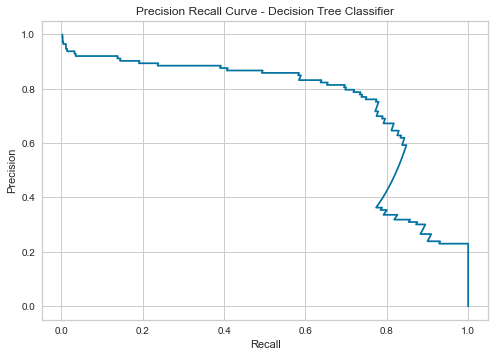

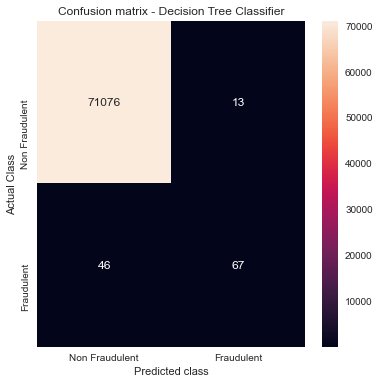

In [32]:
print("Hyperparameter Logistic Regression")
print("==================================")
print("Accuracy: ",accuracy_score(y_test.flatten(), hypertunedLogisticRegressionModelPredictions)) 
print("Precision: ",precision_score(y_test.flatten(), hypertunedLogisticRegressionModelPredictions))
print("Recall: ",recall_score(y_test.flatten(), hypertunedLogisticRegressionModelPredictions))
print("F1-Score: ",f1_score(y_test.flatten(), hypertunedLogisticRegressionModelPredictions))
print("AUC score: ",roc_auc_score(y_test.flatten(), hypertunedLogisticRegressionModelPredictions))
print(classification_report(y_test.flatten(), hypertunedLogisticRegressionModelPredictions,
                            target_names=["Non Fraudulent", "Fraudulent"]))
p, r, t = precision_recall_curve(y_test.flatten(), hypertunedLogisticRegressionModelPredictProba)
plt.plot(p, r)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve - Decision Tree Classifier')
confusionMatrix = confusion_matrix(y_test.flatten(), hypertunedLogisticRegressionModelPredictions) 
plt.figure(figsize =(6, 6)) 
sns.heatmap(confusionMatrix, xticklabels = ['Non Fraudulent', 'Fraudulent'],  
            yticklabels = ['Non Fraudulent', 'Fraudulent'], annot = True, fmt ="d"); 
plt.title("Confusion matrix - Decision Tree Classifier") 
plt.ylabel('Actual Class') 
plt.xlabel('Predicted class') 
plt.show() 